In [10]:
!pip install -q transformers datasets evaluate accelerate pycocotools scikit-learn
!pip install -q git+https://github.com/huggingface/accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [11]:
from google.colab import drive
import os
import zipfile
import shutil

drive.mount('/content/drive')

DRIVE_ZIP_PATH = "/content/drive/MyDrive/dataset.zip"

DATASET_DIR = "/content/dataset_root"

if os.path.exists(DATASET_DIR):
    shutil.rmtree(DATASET_DIR)
os.makedirs(DATASET_DIR, exist_ok=True)

print(f"Dataset {DRIVE_ZIP_PATH} to {DATASET_DIR} extracting...")

try:
    with zipfile.ZipFile(DRIVE_ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(DATASET_DIR)
    print("Dataset successfully extracted!")
    print(f"Folder contents: {os.listdir(DATASET_DIR)}")
except FileNotFoundError:
    print(f"ERROR: Zip file not found.: {DRIVE_ZIP_PATH}")
    print("Please check the path.")
except Exception as e:
    print(f"Error: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset /content/drive/MyDrive/dataset.zip to /content/dataset_root extracting...
Dataset successfully extracted!
Folder contents: ['train', 'README.dataset.txt', 'README.roboflow.txt', 'test']


In [12]:
import json
import random

def split_coco_dataset(dataset_dir, split_ratio=0.1):
    train_dir = os.path.join(dataset_dir, "train")
    valid_dir = os.path.join(dataset_dir, "valid")

    train_ann_file = os.path.join(train_dir, "_annotations.coco.json")
    valid_ann_file = os.path.join(valid_dir, "_annotations.coco.json")

    if os.path.exists(valid_dir) and os.path.exists(valid_ann_file):
        print(f"ℹThe valid folder already exists: {valid_dir}. The operation is skipped. Test data was left untouched.")
        return

    if not os.path.exists(train_ann_file):
        print(f"Train annotation file not found: {train_ann_file}. Splitting is not possible.")
        return

    print("Train data is being split for the validation set...")
    os.makedirs(valid_dir, exist_ok=True)

    # Train JSON
    with open(train_ann_file, 'r') as f:
        coco_data = json.load(f)

    images = coco_data['images']
    annotations = coco_data['annotations']
    categories = coco_data['categories']

    # Mix and Divide
    random.shuffle(images)
    split_idx = int(len(images) * (1 - split_ratio))

    train_imgs = images[:split_idx]
    valid_imgs = images[split_idx:]

    print(f"Train: {len(train_imgs)}, Valid: {len(valid_imgs)}")

    # Carry Validation Images
    img_subdir = ""
    if os.path.exists(os.path.join(train_dir, "images")):
        img_subdir = "images"
        os.makedirs(os.path.join(valid_dir, "images"), exist_ok=True)

    for img in valid_imgs:
        file_name = img['file_name']
        src = os.path.join(train_dir, img_subdir, file_name)
        dst = os.path.join(valid_dir, img_subdir, file_name)
        if os.path.exists(src):
            shutil.move(src, dst)
        else:
            base_name = os.path.basename(file_name)
            src_base = os.path.join(train_dir, img_subdir, base_name)
            if os.path.exists(src_base):
                 shutil.move(src_base, dst)

    # Divide the Annotations
    train_img_ids = {img['id'] for img in train_imgs}
    valid_img_ids = {img['id'] for img in valid_imgs}

    train_anns = [ann for ann in annotations if ann['image_id'] in train_img_ids]
    valid_anns = [ann for ann in annotations if ann['image_id'] in valid_img_ids]

    # Save the new JSON files.
    train_data_new = {
        'info': coco_data.get('info', {}),
        'licenses': coco_data.get('licenses', []),
        'categories': categories,
        'images': train_imgs,
        'annotations': train_anns
    }

    valid_data_new = {
        'info': coco_data.get('info', {}),
        'licenses': coco_data.get('licenses', []),
        'categories': categories,
        'images': valid_imgs,
        'annotations': valid_anns
    }

    with open(train_ann_file, 'w') as f:
        json.dump(train_data_new, f)

    with open(valid_ann_file, 'w') as f:
        json.dump(valid_data_new, f)

    print("The validation kit has been successfully created!")

try:
    split_coco_dataset(DATASET_DIR, split_ratio=0.1)
except Exception as e:
    print(f"An error or warning during splitting: {e}")
    print("Normal flow continues...")

Train data is being split for the validation set...
Train: 2804, Valid: 312
The validation kit has been successfully created!


In [13]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from pycocotools.coco import COCO
import albumentations as A

class COCOInstanceSegmentationDataset(Dataset):
    def __init__(self, root_dir, split, processor):
        self.root_dir = root_dir
        self.split = split
        self.processor = processor
        if split == 'train':
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.2),
                A.Perspective(scale=(0.05, 0.1), p=0.4),
                A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.4),
                A.Rotate(limit=15, p=0.3),
                A.GaussNoise(p=0.2),
            ])
        else:
            self.transform = None

        self.img_dir = os.path.join(root_dir, split)
        if not os.path.exists(self.img_dir) or len(os.listdir(self.img_dir)) == 0:
             self.img_dir = os.path.join(root_dir, split, "images")

        self.ann_file = os.path.join(root_dir, split, "_annotations.coco.json")

        if not os.path.exists(self.ann_file):
            raise FileNotFoundError(f"Annotation file not found.: {self.ann_file}")

        # COCO API
        self.coco = COCO(self.ann_file)
        self.img_ids = sorted(self.coco.getImgIds())

        print(f"Split: {split}, Number of images found: {len(self.img_ids)}")

        cats = self.coco.loadCats(self.coco.getCatIds())
        self.cat_id_map = {}
        for cat in cats:
            if cat['name'] == 'empty':
                self.cat_id_map[cat['id']] = 1
            elif cat['name'] == 'occupied':
                self.cat_id_map[cat['id']] = 2
        print(f"Category Match (Roboflow ID -> Model ID): {self.cat_id_map}")


    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])

        image = Image.open(img_path).convert("RGB")
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

        for ann in anns:
            roboflow_cat_id = ann['category_id']
            model_cat_id = self.cat_id_map.get(roboflow_cat_id, 0)

            if model_cat_id > 0:
                ann_mask = self.coco.annToMask(ann)
                mask[ann_mask > 0] = model_cat_id

        if self.transform:
            img_np = np.array(image)

            transformed = self.transform(image=img_np, mask=mask)
            image = Image.fromarray(transformed["image"])
            mask_image = Image.fromarray(transformed["mask"])
        else:
            mask_image = Image.fromarray(mask)

        inputs = self.processor(
            images=image,
            segmentation_maps=mask_image,
            task_inputs=["semantic"],
            return_tensors="pt"
        )

        processed_inputs = {}
        for k, v in inputs.items():
            if isinstance(v, torch.Tensor):
                processed_inputs[k] = v.squeeze(0)
            elif isinstance(v, list) and len(v) > 0:
                processed_inputs[k] = v[0]
            else:
                processed_inputs[k] = v

        return processed_inputs

print("A custom dataset class has been defined.")

A custom dataset class has been defined.


In [14]:
from transformers import Mask2FormerImageProcessor, Mask2FormerForUniversalSegmentation

MODEL_CHECKPOINT = "facebook/mask2former-swin-tiny-coco-instance"

processor = Mask2FormerImageProcessor.from_pretrained(
    MODEL_CHECKPOINT,
    do_resize=True,
    size={"height": 512, "width": 512},
    do_normalize=True,
    ignore_index=255,
)

id2label = {0: "background", 1: "empty", 2: "occupied"}
label2id = {v: k for k, v in id2label.items()}
num_classes = len(id2label)

print(f"{MODEL_CHECKPOINT} model uploading for the class {num_classes}...")

from transformers import Mask2FormerConfig
config = Mask2FormerConfig.from_pretrained(MODEL_CHECKPOINT)
config.no_object_weight = 2.0
config.id2label = id2label
config.label2id = label2id

print(f"Class Weighting is active: no_object_weight = {config.no_object_weight}")

model = Mask2FormerForUniversalSegmentation.from_pretrained(
    MODEL_CHECKPOINT,
    config=config,
    ignore_mismatched_sizes=True,
)
print("The model and processor are ready.")

/usr/local/lib/python3.12/dist-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


facebook/mask2former-swin-tiny-coco-instance model uploading for the class 3...
Class Weighting is active: no_object_weight = 2.0


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-tiny-coco-instance and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([81]) in the checkpoint and torch.Size([4]) in the model instantiated
- class_predictor.weight: found shape torch.Size([81, 256]) in the checkpoint and torch.Size([4, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([81]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The model and processor are ready.


In [15]:
# Train Set
print("Train set is loading...")
train_dataset = COCOInstanceSegmentationDataset(
    root_dir=DATASET_DIR,
    split='train',
    processor=processor
)

# Validation
print("Valid (Eval) set is loading..")
if os.path.exists(os.path.join(DATASET_DIR, 'valid')):
     eval_dataset = COCOInstanceSegmentationDataset(
        root_dir=DATASET_DIR,
        split='valid',
        processor=processor
    )
else:
     print("The validation folder could not be found.")
     eval_dataset = None

# Test Set
print("Test set is loading...")
if os.path.exists(os.path.join(DATASET_DIR, 'test')):
    test_dataset = COCOInstanceSegmentationDataset(
        root_dir=DATASET_DIR,
        split='test',
        processor=processor
    )
    print("Test set successfully loaded..")
else:
    print("Test folder not found.")
    test_dataset = None

print(f"Train data number: {len(train_dataset)}")
if eval_dataset: print(f"Validation data number: {len(eval_dataset)}")
if test_dataset: print(f"Test data number: {len(test_dataset)}")

Train set is loading...
loading annotations into memory...
Done (t=0.11s)
creating index...


/tmp/ipython-input-2044818127.py:19: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.4),


index created!
Split: train, Number of images found: 2804
Category Match (Roboflow ID -> Model ID): {0: 1, 1: 1, 2: 2}
Valid (Eval) set is loading..
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Split: valid, Number of images found: 312
Category Match (Roboflow ID -> Model ID): {0: 1, 1: 1, 2: 2}
Test set is loading...
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Split: test, Number of images found: 346
Category Match (Roboflow ID -> Model ID): {0: 1, 1: 1, 2: 2}
Test set successfully loaded..
Train data number: 2804
Validation data number: 312
Test data number: 346


In [16]:
import torch

def collate_fn(batch):
    pixel_values = torch.stack([example["pixel_values"] for example in batch])
    pixel_mask = torch.stack([example["pixel_mask"] for example in batch])

    mask_labels = [example["mask_labels"] for example in batch]
    class_labels = [example["class_labels"] for example in batch]

    return {
        "pixel_values": pixel_values,
        "pixel_mask": pixel_mask,
        "mask_labels": mask_labels,
        "class_labels": class_labels,
    }
print("Collate function is ready.")

Collate function is ready.


In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import os

os.environ["WANDB_DISABLED"] = "true"

OUTPUT_DIR = "/content/drive/MyDrive/Proje/mask2former_parking_output_v4"

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    learning_rate=5e-5,
    num_train_epochs=15,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    save_strategy="epoch",
    eval_strategy="epoch" if eval_dataset else "no",
    save_total_limit=2,
    logging_steps=50,
    remove_unused_columns=False,
    fp16=True,
    dataloader_num_workers=4,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
    tokenizer=processor,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("Train is starting...")
trainer.train()
print("Train is completed!")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-1229846681.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Eğitim başlıyor...


/usr/local/lib/python3.12/dist-packages/transformers/models/mask2former/image_processing_mask2former.py:600: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.preprocess` and were ignored: 'task_inputs'
  return self.preprocess(images, segmentation_maps=segmentation_maps, **kwargs)
/usr/local/lib/python3.12/dist-packages/transformers/models/mask2former/image_processing_mask2former.py:600: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.preprocess` and were ignored: 'task_inputs'
  return self.preprocess(images, segmentation_maps=segmentation_maps, **kwargs)
/usr/local/lib/python3.12/dist-packages/transformers/models/mask2former/image_processing_mask2former.py:600: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.preprocess` and were ignored: 'task_inputs'
  return self.preprocess(images, segmentation_maps=segmentation_maps, **kwargs)
/usr/local/lib/python3.12/dist-packag

Epoch,Training Loss,Validation Loss
1,16.870100,15.992673
2,14.887600,14.022090
3,13.453000,13.161677
4,12.139200,12.566252
5,13.034400,12.251920
6,12.449600,12.026909
7,12.002200,11.805177
8,11.033200,11.620879
9,10.501200,11.902346
10,10.323100,11.746887


/usr/local/lib/python3.12/dist-packages/transformers/models/mask2former/image_processing_mask2former.py:600: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.preprocess` and were ignored: 'task_inputs'
  return self.preprocess(images, segmentation_maps=segmentation_maps, **kwargs)
/usr/local/lib/python3.12/dist-packages/transformers/models/mask2former/image_processing_mask2former.py:600: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.preprocess` and were ignored: 'task_inputs'
  return self.preprocess(images, segmentation_maps=segmentation_maps, **kwargs)
/usr/local/lib/python3.12/dist-packages/transformers/models/mask2former/image_processing_mask2former.py:600: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.preprocess` and were ignored: 'task_inputs'
  return self.preprocess(images, segmentation_maps=segmentation_maps, **kwargs)
/usr/local/lib/python3.12/dist-packag

Eğitim tamamlandı!


In [17]:
import torch
import numpy as np
import time
from tqdm import tqdm
from transformers import Mask2FormerImageProcessor, Mask2FormerForUniversalSegmentation
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score

CHECKPOINT_PATH = "/content/drive/MyDrive/Proje/mask2former_parking_output_v4/checkpoint-3861"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Evaluation Model Loading: {CHECKPOINT_PATH}")

processor = Mask2FormerImageProcessor.from_pretrained(CHECKPOINT_PATH, ignore_index=255)
model = Mask2FormerForUniversalSegmentation.from_pretrained(CHECKPOINT_PATH).to(DEVICE)
model.eval()

if 'test_dataset' not in locals() or test_dataset is None:
    if 'eval_dataset' in locals() and eval_dataset is not None:
        print("WARNING: The 'test' dataset could not be found. The 'valid' dataset is being used for evaluation.")
        test_dataset = eval_dataset
    else:
        raise ValueError("ERROR: No dataset found to test.")

eval_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

def calculate_pixel_metrics(pred_mask, true_mask, class_id):

    p = (pred_mask == class_id).astype(int).flatten()
    t = (true_mask == class_id).astype(int).flatten()

    if t.sum() == 0 and p.sum() == 0:
        return np.nan, np.nan, np.nan, np.nan

    precision = precision_score(t, p, zero_division=0)
    recall = recall_score(t, p, zero_division=0)
    f1 = f1_score(t, p, zero_division=0)

    intersection = np.logical_and(p, t).sum()
    union = np.logical_or(p, t).sum()
    iou = intersection / (union + 1e-6)

    return iou, precision, recall, f1

print("Detailed metrics (FPS, F1, mAP) are being calculated on the test set...")

metrics = {
    "empty": {"iou": [], "precision": [], "recall": [], "f1": []},
    "occupied": {"iou": [], "precision": [], "recall": [], "f1": []}
}

total_inference_time = 0
total_frames = 0

for idx, batch in tqdm(enumerate(eval_dataloader), total=len(eval_dataloader)):

    pixel_values = batch["pixel_values"].to(DEVICE)
    start_time = time.time()

    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)

    end_time = time.time()
    total_inference_time += (end_time - start_time)
    total_frames += 1

    img_id = test_dataset.img_ids[idx]
    ann_ids = test_dataset.coco.getAnnIds(imgIds=img_id)
    anns = test_dataset.coco.loadAnns(ann_ids)
    img_info = test_dataset.coco.loadImgs(img_id)[0]

    true_mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
    for ann in anns:
        roboflow_cat_id = ann['category_id']
        model_cat_id = test_dataset.cat_id_map.get(roboflow_cat_id, 0)
        if model_cat_id > 0:
            m = test_dataset.coco.annToMask(ann)
            true_mask[m > 0] = model_cat_id

    target_sizes = [(img_info['height'], img_info['width'])]
    pred_map = processor.post_process_semantic_segmentation(outputs, target_sizes=target_sizes)[0]
    pred_mask = pred_map.cpu().numpy()

    iou_e, prec_e, rec_e, f1_e = calculate_pixel_metrics(pred_mask, true_mask, class_id=1)
    if not np.isnan(iou_e):
        metrics["empty"]["iou"].append(iou_e)
        metrics["empty"]["precision"].append(prec_e)
        metrics["empty"]["recall"].append(rec_e)
        metrics["empty"]["f1"].append(f1_e)

    iou_o, prec_o, rec_o, f1_o = calculate_pixel_metrics(pred_mask, true_mask, class_id=2)
    if not np.isnan(iou_o):
        metrics["occupied"]["iou"].append(iou_o)
        metrics["occupied"]["precision"].append(prec_o)
        metrics["occupied"]["recall"].append(rec_o)
        metrics["occupied"]["f1"].append(f1_o)

fps = total_frames / total_inference_time if total_inference_time > 0 else 0

print("\n" + "="*40)
print(f"PERFORMANCE REPORT")
print("="*40)
print(f"SPEED: {fps:.2f} FPS (Frame Per Second)")
print("-" * 40)

def print_stat(name, values):
    if len(values) > 0:
        mean_val = np.mean(values) * 100
        print(f"{name}: %{mean_val:.2f}")
    else:
        print(f"{name}: No data available.")

print("\n--- EMPTY PARKING SPACES ---")
print_stat("IoU", metrics["empty"]["iou"])
print_stat("Precision", metrics["empty"]["precision"])
print_stat("Recall", metrics["empty"]["recall"])
print_stat("F1-Score", metrics["empty"]["f1"])

print("\n--- OCCUPIED PARKING SPACES ---")
print_stat("IoU", metrics["occupied"]["iou"])
print_stat("Precision", metrics["occupied"]["precision"])
print_stat("Recall", metrics["occupied"]["recall"])
print_stat("F1-Score", metrics["occupied"]["f1"])

print("\n--- GENERAL AVERAGE ---")
mIoU = (np.mean(metrics["empty"]["iou"]) + np.mean(metrics["occupied"]["iou"])) / 2 * 100
mF1 = (np.mean(metrics["empty"]["f1"]) + np.mean(metrics["occupied"]["f1"])) / 2 * 100
print(f"Mean IoU: %{mIoU:.2f}")
print(f"Mean F1-Score: %{mF1:.2f}")
print("="*40)

Evaluation Model Loading: /content/drive/MyDrive/Proje/mask2former_parking_output_v4/checkpoint-3861
Detailed metrics (FPS, F1, mAP) are being calculated on the test set...


  0%|          | 0/346 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/transformers/models/mask2former/image_processing_mask2former.py:600: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.preprocess` and were ignored: 'task_inputs'
  return self.preprocess(images, segmentation_maps=segmentation_maps, **kwargs)
  0%|          | 1/346 [00:00<02:49,  2.03it/s]/usr/local/lib/python3.12/dist-packages/transformers/models/mask2former/image_processing_mask2former.py:600: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.preprocess` and were ignored: 'task_inputs'
  return self.preprocess(images, segmentation_maps=segmentation_maps, **kwargs)
  1%|          | 2/346 [00:01<03:03,  1.88it/s]/usr/local/lib/python3.12/dist-packages/transformers/models/mask2former/image_processing_mask2former.py:600: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.preprocess` and were ignored


PERFORMANCE REPORT
SPEED: 18.29 FPS (Frame Per Second)
----------------------------------------

--- EMPTY PARKING SPACES ---
IoU: %53.64
Precision: %75.98
Recall: %63.44
F1-Score: %66.27

--- OCCUPIED PARKING SPACES ---
IoU: %93.59
Precision: %96.32
Recall: %96.76
F1-Score: %96.33

--- GENERAL AVERAGE ---
Mean IoU: %73.62
Mean F1-Score: %81.30


In [18]:
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch

def visualize_predictions(dataset, model, processor, target_files=None, num_samples=3):
    model.eval()
    if dataset is None or len(dataset) == 0:
        print("Görselleştirme için veri seti bulunamadı veya boş.")
        return

    indices = []
    if target_files:
        print(f"{len(target_files)} private files are being sought...")
        found_files = set()
        for idx, img_id in enumerate(dataset.img_ids):
            img_info = dataset.coco.loadImgs(img_id)[0]
            if img_info['file_name'] in target_files:
                indices.append(idx)
                found_files.add(img_info['file_name'])

        missing = set(target_files) - found_files
        if missing:
            print(f"WARNING: These files were not found in the dataset: {missing}")
    else:
        if len(dataset) < num_samples:
            num_samples = len(dataset)
        indices = random.sample(range(len(dataset)), num_samples)

    if not indices:
        print("No image was found to display.")
        return

    for idx in indices:
        img_id = dataset.img_ids[idx]
        img_info = dataset.coco.loadImgs(img_id)[0]
        file_name = img_info['file_name']
        img_path = os.path.join(dataset.img_dir, file_name)
        image = Image.open(img_path).convert("RGB")
        w, h = image.size

        ann_ids = dataset.coco.getAnnIds(imgIds=img_id)
        anns = dataset.coco.loadAnns(ann_ids)
        true_mask = np.zeros((h, w), dtype=np.uint8)
        for ann in anns:
             m_cat = dataset.cat_id_map.get(ann['category_id'], 0)
             if m_cat > 0:
                 m = dataset.coco.annToMask(ann)
                 true_mask[m > 0] = m_cat

        inputs = processor(images=image, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs.to(DEVICE))

        target_sizes = [(h, w)]
        pred_map = processor.post_process_semantic_segmentation(outputs, target_sizes=target_sizes)[0]
        pred_mask = pred_map.cpu().numpy()

        def create_overlay(base_img, mask):
            overlay = np.zeros((h, w, 4), dtype=np.uint8)

            overlay[mask == 1] = [0, 255, 0, 100]   # green
            overlay[mask == 2] = [255, 0, 0, 100]   # red

            overlay_img = Image.fromarray(overlay, mode="RGBA")

            base_rgba = base_img.convert("RGBA")
            combined = Image.alpha_composite(base_rgba, overlay_img)
            return combined.convert("RGB")

        img_gt_overlay = create_overlay(image, true_mask)
        img_pred_overlay = create_overlay(image, pred_mask)

        fig, axes = plt.subplots(1, 2, figsize=(16, 8))

        axes[0].imshow(img_gt_overlay)
        axes[0].set_title(f"Ground Truth\n{file_name}")
        axes[0].axis('off')

        axes[1].imshow(img_pred_overlay)
        axes[1].set_title(f"Prediction\nGreen: Empty | Red: Full")
        axes[1].axis('off')

        plt.show()

4 private files are being sought...


/tmp/ipython-input-495201674.py:66: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  overlay_img = Image.fromarray(overlay, mode="RGBA")


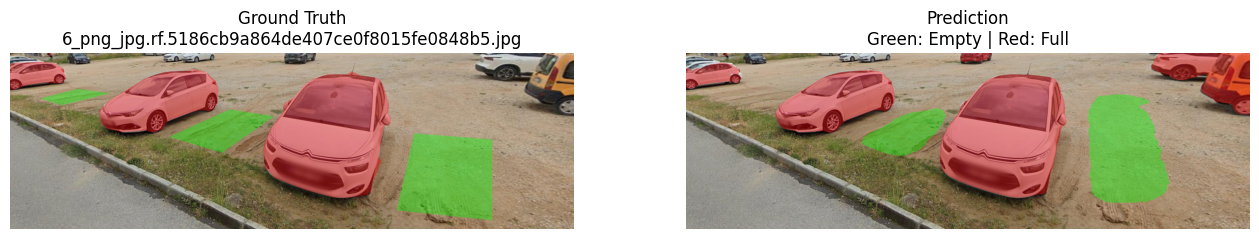

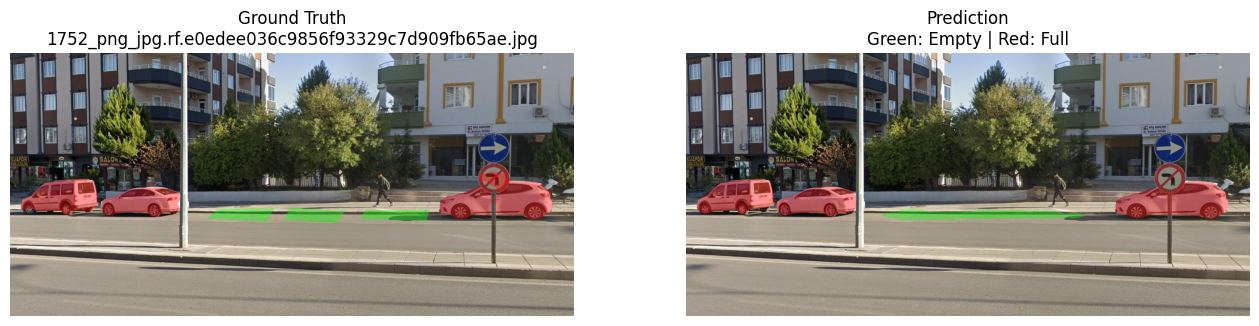

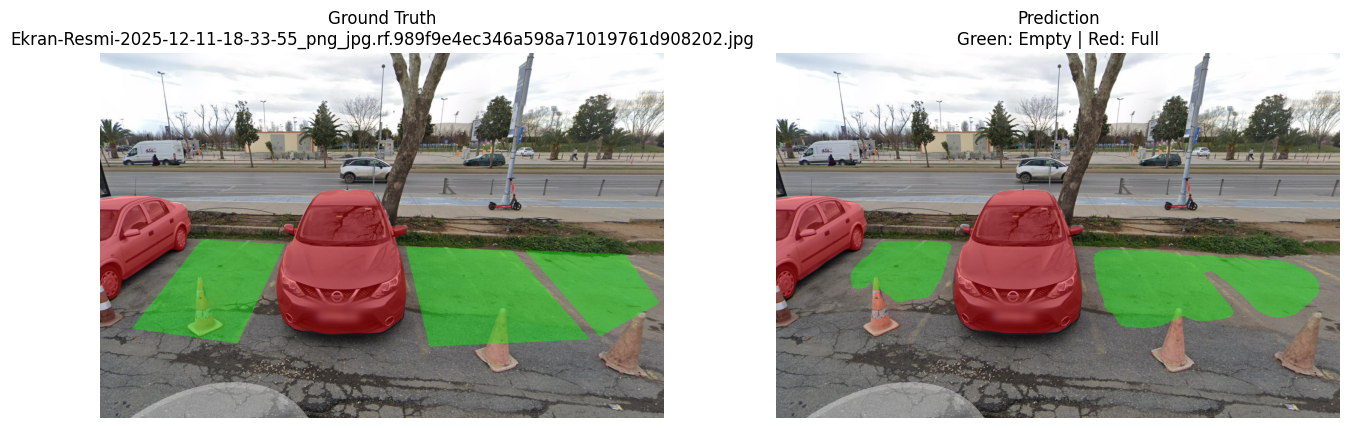

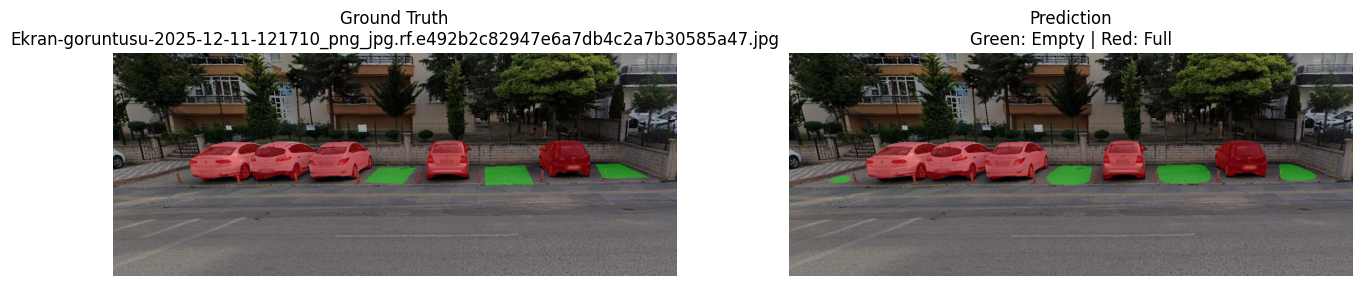

In [19]:
target_files = [
    "Ekran-Resmi-2025-12-11-18-33-55_png_jpg.rf.989f9e4ec346a598a71019761d908202.jpg",
    "Ekran-goruntusu-2025-12-11-121710_png_jpg.rf.e492b2c82947e6a7db4c2a7b30585a47.jpg",
    "1752_png_jpg.rf.e0edee036c9856f93329c7d909fb65ae.jpg",
    "6_png_jpg.rf.5186cb9a864de407ce0f8015fe0848b5.jpg"
]

visualize_predictions(test_dataset, model, processor, target_files=target_files)